In [ ]:
# Can wearable sensor data predict whether dyskinesia is present?
# resting limbs during bilateral uppperlimb movements? 
# Dyskinesias are involuntary, erratic, writhing movements of the face, arms, legs or trunk. 

# Reference: 
# https://www.parkinson.org/Understanding-Parkinsons/Symptoms/Movement-Symptoms/Bradykinesia-Slowness-of-Movement


In [1]:
# Core
import pandas as pd
import os
import numpy as np
from numpy import set_printoptions, sqrt, argmax
from numpy.random import permutation
import scipy.stats as stats
from itertools import compress
import matplotlib.pyplot as plt
import seaborn as sns
import time

#tsfresh
import tsfresh
from tsfresh.feature_extraction import extract_features, MinimalFCParameters, EfficientFCParameters
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

# Sklearn
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Self-defined functions
from Utilities import pdVarianceThreshold, pdSelectKBest, train_val_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
direc = "E:\\WS4PD_data"
os.chdir(direc)
save_path = os.path.join(direc, "Model_validation", "GENEActiv_dyskinesia")

In [3]:
# Load score data
score_file_path = os.path.join(direc, 'Feature_extraction','score_by_device.pkl')
df_score = pd.read_pickle(score_file_path)

In [4]:
# load feature data
subject_ids = df_score.subject_id.unique()
df_feature = pd.DataFrame()
device = 'GENEActiv'
for sb in subject_ids:
    feature_file_path = os.path.join(direc,'Feature_extraction',device,sb + '_features.pkl')
    df_feature_sb = pd.read_pickle(feature_file_path)
    df_feature = pd.concat([df_feature,df_feature_sb])
df_feature = df_feature.reset_index(drop=True)

In [5]:
# load clinical features
meta_file_path = os.path.join(direc, 'Feature_extraction','metadata_features.pkl')
df_meta = pd.read_pickle(meta_file_path)

# drop subject_id and task_code 
# df_meta.drop(columns = ['subject_id', 'task_code'])
df_meta = df_meta.drop(columns = 'subject_id')

# One-hot encoding clinical/ categorical features
categorical_columns = df_meta.columns
for column in categorical_columns:
    tempdf = pd.get_dummies(df_meta[column], prefix=column)
    df_meta = pd.merge(
        left=df_meta,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    df_meta = df_meta.drop(columns=column)
print(df_meta.shape)

(6909, 69)


In [ ]:
# # Select trials from lowerlimb tasks
# task = ['wlkgs', 'wlkgc', 'wlkgp', 'strsu', 'strsd', 'ststd']
# task = ['ftnr', 'ftnl', 'ramr', 'raml', 'drawg', 'typng', 'ntblt', 'drnkg', 'orgpa', 'fldng']
# task = ['stndg', 'sittg']
# # task_name = 'no voluntary movement'
# is_tasks = df_score['task_code'].isin(task).tolist()
# df_feature = df_feature[is_tasks]
# df_score = df_score[is_tasks]
# df_meta = df_meta[is_tasks]

In [ ]:
# # Add subject id as a new feature
# dummy_id = pd.get_dummies(df_score['subject_id'])

# # Add task code as a new feature
# dummy_task = pd.get_dummies(df_score['task_code'])

# # Combine subject id and task code as meta features
# df_meta = pd.concat([dummy_id,dummy_task], axis=1)

# print(df_meta.shape)

In [ ]:
# Add task code as a new feature
# dummy_task = pd.get_dummies(df_score['task_code'])
# dummy_task
# enc = OneHotEncoder(handle_unknown='ignore')
# id_and_task = enc.fit_transform([df_score['subject_id'], df_score['task_code']])

In [ ]:
df_score

In [ ]:
# # Try different task categories
# # task categories
# task_groups = [['stndg', 'sittg', 'wlkgs', 'wlkgc', 'wlkgp', 'strsu', 'strsd', 'ststd',
#               'ftnr', 'ftnl', 'ramr', 'raml', 'drawg', 'typng', 'ntblt', 'drnkg', 'orgpa', 'fldng'],
#                ['stndg', 'sittg'],['wlkgs', 'wlkgc', 'wlkgp', 'strsu', 'strsd', 'ststd'],
#                ['ftnr', 'ftnl', 'ramr', 'raml', 'drawg', 'typng', 'ntblt', 'drnkg', 'orgpa', 'fldng']]
# task_group_names = ['all', 'no_voluntary_movement','lowerlimb_movement', 'upperlimb_movement']

In [ ]:
# Train/Validation/Test datasets

# train:validation:test = 0.5:0.25:0.25
sb_train = ['6_BOS', '16_BOS', '7_NYC', '14_BOS', '8_NYC', '5_BOS', '12_NYC', '6_NYC', '17_BOS',
           '4_BOS', '11_BOS', '10_BOS', '15_BOS', '4_NYC', '11_NYC']
sb_val = ['8_BOS', '18_BOS', '2_NYC', '9_NYC', '3_BOS', '9_BOS']
sb_test = ['19_BOS', '3_NYC', '7_BOS', '5_NYC', '13_BOS', '10_NYC', '12_BOS']

In [6]:
# Create a new label 
is_dyskinesia = df_score['dyskinesia_GENEActivHand'] == 'Yes'
df_score['newDyskinesia_GENEActivHand'] = 0
df_score['newDyskinesia_GENEActivHand'].loc[is_dyskinesia] = 1

title_name = 'is dyskinesia'
save_name = 'is_dyskinesia'
xtick_name = [0,1,2]

bin_range = range(3)

array([6164,  745], dtype=int64)

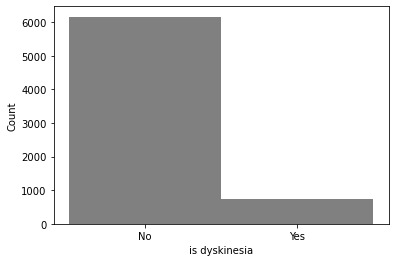

In [7]:
# Get new score distribution
score = df_score['newDyskinesia_GENEActivHand'].values
    
# score distribution
counts, bin_edges = np.histogram(score,bins = bin_range)
fig, ax = plt.subplots()
ax.hist(score, bins = bin_range, histtype='bar', color = 'grey')
ax.set_xlabel(title_name)
ax.set_ylabel('Count')
ax.set_xticks([0.5,1.5], labels = ['No', 'Yes'])
# plt.savefig(os.path.join(save_path,"Tremor_score_distribution"))
counts

In [8]:
# Up-sampling
upsampled_df_feature = pd.DataFrame()
upsampled_df_score = pd.DataFrame()
upsample_size = round(max(counts)/2)
upsampled_df_meta = pd.DataFrame()
for s,c in enumerate(counts[0:2]):
    if c == max(counts[0:2]):
        upsampled_feature_group = df_feature.loc[score==s]
        upsampled_score_group = df_score.loc[score==s]
        upsampled_meta_group = df_meta.loc[score==s]
    else:
        df_feature_group = df_feature.loc[score==s]
        df_score_group = df_score.loc[score==s]
        df_meta_group = df_meta.loc[score==s]
        idx_list = df_feature_group.index.tolist()
        resample_idx = resample(idx_list, replace=True, n_samples=upsample_size, random_state=27)
        upsampled_feature_group = df_feature_group.loc[resample_idx]
        upsampled_score_group = df_score_group.loc[resample_idx]
        upsampled_meta_group = df_meta_group.loc[resample_idx]

    upsampled_df_feature = pd.concat([upsampled_df_feature, upsampled_feature_group])
    upsampled_df_score = pd.concat([upsampled_df_score, upsampled_score_group])
    upsampled_df_meta = pd.concat([upsampled_df_meta, upsampled_meta_group])
    
upsampled_df_feature = upsampled_df_feature.reset_index(drop=True)
upsampled_df_score = upsampled_df_score.reset_index(drop=True)
upsampled_df_meta = upsampled_df_meta.reset_index(drop=True)

print('upsampled features:' + str(upsampled_df_feature.shape))
print('upsampled scores:' + str(upsampled_df_score.shape))
print('upsampled meta:' + str(upsampled_df_meta.shape))
# Try other upsmapling methods:
# from imblearn.over_sampling import SMOTE

upsampled features:(9246, 2262)
upsampled scores:(9246, 12)
upsampled meta:(9246, 69)


In [9]:
df_feature = upsampled_df_feature
df_score = upsampled_df_score
df_meta = upsampled_df_meta

In [10]:
# Classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0, solver = 'liblinear'),
    "KNN" : KNeighborsClassifier(),
#     "SVC" : SVC(random_state=0, probability=True),
    "RandomForest" : RandomForestClassifier(random_state=0),
    "XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'), # XGBoost takes too long
    "LGBM" : LGBMClassifier(random_state=0),
#     "CatBoost" : CatBoostClassifier(random_state=0, verbose=False),
    "NaiveBayes": GaussianNB()
}

# Grids for grid search
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

# SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
#             'kernel': ['linear', 'rbf'],
#             'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [2, 4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

NB_grid={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

# Dictionary of all grids
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
#     "SVC" : SVC_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
#     "CatBoost" : boosted_grid,
    "NaiveBayes": NB_grid
}

In [12]:
## Get data
# Combine sensor features with clinical features
df = pd.concat([df_feature, df_meta], axis=1) 
# Get scores
score = df_score['newDyskinesia_GENEActivHand']

## Set parameters
varThreshold = 0.0001
k_num = 10

# Remove features with nan
df2 = df.dropna(axis=1)

# Remove features with zero variance
df3 = pdVarianceThreshold(df2,varThreshold)

# Univariant selection
df4 = pdSelectKBest(df3,score,k_num)

# Train/Validation/Test Split
subject_id = df_score['subject_id']
X_train_valid, y_train_valid, X_train, y_train,  X_valid, y_valid, X_test, y_test = train_val_test_split(df4, score, subject_id)


In [13]:
# Classifier evaluation
i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(),
                           'Accuracy': np.zeros(len(classifiers)),
                           'F1_macro': np.zeros(len(classifiers)),
                           'F1_micro': np.zeros(len(classifiers)),
                           'F1_weighted': np.zeros(len(classifiers)),
                           'F1_0': np.zeros(len(classifiers)),
                           'F1_1': np.zeros(len(classifiers)),                               
                           'Precision_0': np.zeros(len(classifiers)),
                           'Precision_1': np.zeros(len(classifiers)),
                           'Recall_0': np.zeros(len(classifiers)),
                           'Recall_1': np.zeros(len(classifiers)),
                           'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    Accuracy = accuracy_score(y_valid, y_pred).round(2)
    F1_macro = f1_score(y_valid, y_pred, average = 'macro').round(2)
    F1_micro = f1_score(y_valid, y_pred, average = 'micro').round(2)
    F1_weighted = f1_score(y_valid, y_pred, average = 'weighted').round(2)
    F1_class = f1_score(y_valid, y_pred, average = None).round(2)
    Precision = precision_score(y_valid, y_pred, average = None).round(2)
    Recall = recall_score(y_valid, y_pred, average = None).round(2)                                         

    valid_scores.iloc[i,1]=Accuracy
    valid_scores.iloc[i,2]=F1_macro
    valid_scores.iloc[i,3]=F1_micro
    valid_scores.iloc[i,4]=F1_weighted
    valid_scores.iloc[i,5]=F1_class[0]
    valid_scores.iloc[i,6]=F1_class[1]
    valid_scores.iloc[i,7]=Precision[0]
    valid_scores.iloc[i,8]=Precision[1] 
    valid_scores.iloc[i,9]=Recall[0]
    valid_scores.iloc[i,10]=Recall[1]

    # Save trained model
    clf_best_params[key]=clf.best_params_

    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,11]=np.round((stop - start)/60, 2)


    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,11])
    print('')
    i+=1

C:\Users\Yiting\Anaconda3\envs\ws4pd\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LogisticRegression
Training time (mins): 0.16

Model: KNN
Training time (mins): 0.01

Model: RandomForest
Training time (mins): 0.32

Model: XGBoost
Training time (mins): 0.35

Model: LGBM
Training time (mins): 0.09

Model: NaiveBayes
Training time (mins): 0.0



In [14]:
recall_1_threshold = 0.7

# Select best classifier based on recall threshold for the positive class and F1 score
is_good_recall_1 = valid_scores['Recall_1'] > recall_1_threshold
if sum(is_good_recall_1) == 0: # recall 1 is below the threshold 
    best_recall_1 = valid_scores['Recall_1'].max()
    is_best = valid_scores['Recall_1'] == best_recall_1
    if sum(is_best)>1: # duplicate max recall scores -> compare F1 score
        max_index = valid_scores['F1_micro'].loc[is_best].idxmax()
    else:
        max_index = [index for index, element in enumerate(is_best) if element] 
        max_index = max_index[0]
    best_clf = valid_scores['Classifer'].iloc[max_index]
    training_time = valid_scores['Training time'].iloc[max_index]
    best_clf_params = clf_best_params[best_clf]
    best_F1_micro = valid_scores['F1_micro'].iloc[max_index]

else: # recall 1 is above the threshold -> select the best classifier based on F1 score
    best_F1_micro = valid_scores['F1_micro'].loc[is_good_recall_1].max()
    is_best = valid_scores['F1_micro'] == best_F1_micro
    if sum(is_best)>1: # duplicate max F1 scores -> compare recall score
        max_index = valid_scores['Recall_1'].loc[is_best].idxmax()
    else:
        max_index = [index for index, element in enumerate(is_best) if element] 
        max_index = max_index[0]
    best_clf = valid_scores['Classifer'].iloc[max_index]
    training_time = valid_scores['Training time'].iloc[max_index]
    best_clf_params = clf_best_params[best_clf] 
    best_recall_1 = valid_scores['Recall_1'].iloc[max_index]

clf_summary = pd.DataFrame({'title': [title_name],
         'max_sample_size': [max(counts)],
         'upsample_size': [upsample_size],
         'best_F1_micro': [best_F1_micro],            
         'best_recall_1': [best_recall_1],
         'best_clf': [best_clf],
         'best_clf_params': [best_clf_params],                         
         'valid_scores': [valid_scores]},
          index=[0])

In [15]:
clf_summary

,title,max_sample_size,upsample_size,best_F1_micro,best_recall_1,best_clf,best_clf_params,valid_scores
0,is dyskinesia,6164,3082,0.56,0.8,NaiveBayes,{'var_smoothing': 1e-10},Classifer Accuracy F1_macro F1_...


In [16]:
valid_scores

,Classifer,Accuracy,F1_macro,F1_micro,F1_weighted,F1_0,F1_1,Precision_0,Precision_1,Recall_0,Recall_1,Training time
0,LogisticRegression,0.55,0.36,0.55,0.39,0.71,0.00,0.55,0.00,1.00,0.00,0.16
1,KNN,0.57,0.47,0.57,0.49,0.70,0.24,0.57,0.55,0.90,0.15,0.01
2,RandomForest,0.58,0.46,0.58,0.49,0.71,0.20,0.57,0.64,0.95,0.12,0.32
3,XGBoost,0.59,0.47,0.59,0.49,0.72,0.21,0.58,0.71,0.96,0.12,0.35
4,LGBM,0.57,0.44,0.57,0.47,0.71,0.17,0.57,0.63,0.95,0.10,0.09
5,NaiveBayes,0.56,0.55,0.56,0.55,0.49,0.62,0.70,0.51,0.37,0.80,0.00


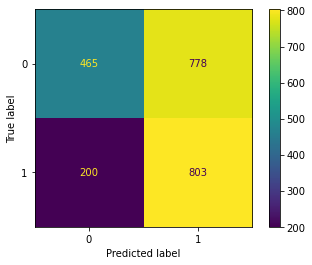

In [17]:
cm = confusion_matrix(y_valid, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

Best Threshold=0.999999, G-Mean=0.628


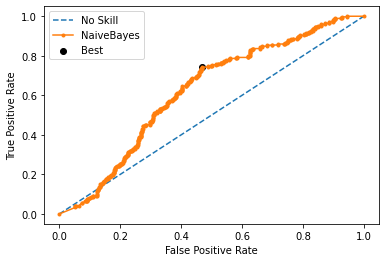

In [18]:
# ROC curve
# predict probabilities
yhat = clf.predict_proba(X_valid)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_valid, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label=best_clf)
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

(array([6.64e+02, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        1.00e+00, 1.58e+03, 0.00e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05]),
 <BarContainer object of 21 artists>)

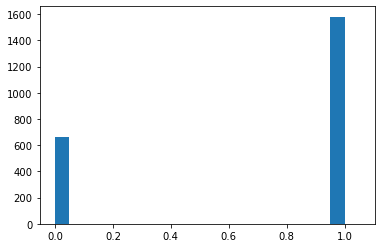

In [19]:
plt.hist(yhat, bins = np.arange(0, 1.1, 0.05))


Best Threshold=0.999999, F-Score=0.639
Recall=0.743, Precision=0.561


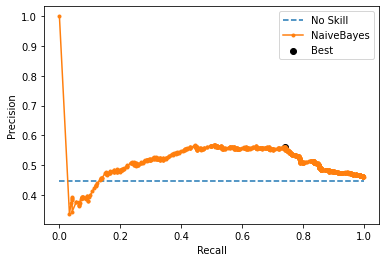

In [27]:
# PR curve
precision, recall, thresholds = precision_recall_curve(y_valid, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print('Recall=%.3f, Precision=%.3f' % (recall[ix], precision[ix]))
# plot the pr curve for the model
no_skill = len(y_valid[y_valid==1]) / len(y_valid)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label=best_clf)
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [34]:
is_good_recall = recall > recall_1_threshold
ix = np.argmax(precision[is_good_recall])
new_y_pred = yhat > thresholds[ix]
Accuracy = accuracy_score(y_valid, y_pred).round(2)
F1_micro = f1_score(y_valid, new_y_pred, average = 'micro').round(2)
Precision = precision_score(y_valid, new_y_pred, average = None).round(2)
Recall = recall_score(y_valid, new_y_pred, average = None).round(2)  

In [38]:
precision[ix]

0.5614167294649586

In [21]:
is_good_recall = recall > recall_1_threshold

good_recall_idx = [index for index, element in enumerate(is_good_recall) if element]
ix = good_recall_idx[-1]
new_y_pred = yhat > thresholds[ix]
Accuracy = accuracy_score(y_valid, y_pred).round(2)
F1_micro = f1_score(y_valid, new_y_pred, average = 'micro').round(2)
Precision = precision_score(y_valid, new_y_pred, average = None).round(2)
Recall = recall_score(y_valid, new_y_pred, average = None).round(2)      

In [35]:
F1_micro

0.62

In [36]:
Precision

array([0.72, 0.56])

In [37]:
Recall

array([0.53, 0.74])

In [ ]:
# Combine sensor features with clinical features
# df = pd.concat([df_feature, df_meta], axis=1)
# print(df.shape)

df = df_feature

In [ ]:
recall_1_threshold = 0.7

In [ ]:

# Remove features with nan
df_feature2 = df.dropna(axis=1)

# Remove features with zero variance
sel = VarianceThreshold(threshold=0.0001)
df_feature3 = sel.fit_transform(df_feature2)
filter3 = sel.get_support()
feature_names2 = df_feature2.columns
feature_names3 = feature_names2[filter3]
df_feature3 = pd.DataFrame(df_feature3, columns=feature_names3)

# Get scores
score = df_score['newDyskinesia_GENEActivHand']


# Univariate Selection
test = SelectKBest(score_func=f_classif, k=30)
df_feature4 = test.fit_transform(df_feature3, score)
filter4 = test.get_support()
feature_names4 = feature_names3[filter4]
df_feature4 = pd.DataFrame(df_feature4, columns=feature_names4)

# PCA
X=df_feature4.values
pca = PCA(n_components=5)
X_new = pca.fit_transform(X)

# # Combine waveform feature with task code feature
# X_task = upsampled_df_dummy_task.to_numpy()
# X_new = np.concatenate((X_new, X_task), axis=1)

# Train/Validation/Test Split
is_train = df_score['subject_id'].isin(sb_train).tolist()
is_val = df_score['subject_id'].isin(sb_val).tolist()
is_test = df_score['subject_id'].isin(sb_test).tolist()
is_train_val = df_score['subject_id'].isin(sb_train) | df_score['subject_id'].isin(sb_val)
is_train_val = is_train_val.tolist()

X_train_valid = X_new[is_train_val,:]
y_train_valid = score[is_train_val]
X_train = X_new[is_train,:]
y_train = score[is_train]
X_valid = X_new[is_val,:]
y_valid = score[is_val]
X_test = X_new[is_test,:]
y_test = score[is_test]

# Classifier evaluation
i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(),
                           'Accuracy': np.zeros(len(classifiers)),
                           'F1_macro': np.zeros(len(classifiers)),
                           'F1_micro': np.zeros(len(classifiers)),
                           'F1_weighted': np.zeros(len(classifiers)),
                           'F1_0': np.zeros(len(classifiers)),
                           'F1_1': np.zeros(len(classifiers)),                               
                           'Precision_0': np.zeros(len(classifiers)),
                           'Precision_1': np.zeros(len(classifiers)),
                           'Recall_0': np.zeros(len(classifiers)),
                           'Recall_1': np.zeros(len(classifiers)),
                           'Training time': np.zeros(len(classifiers))})

for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    Accuracy = accuracy_score(y_valid, y_pred).round(2)
    F1_macro = f1_score(y_valid, y_pred, average = 'macro').round(2)
    F1_micro = f1_score(y_valid, y_pred, average = 'micro').round(2)
    F1_weighted = f1_score(y_valid, y_pred, average = 'weighted').round(2)
    F1_class = f1_score(y_valid, y_pred, average = None).round(2)
    Precision = precision_score(y_valid, y_pred, average = None).round(2)
    Recall = recall_score(y_valid, y_pred, average = None).round(2)                                         

    valid_scores.iloc[i,1]=Accuracy
    valid_scores.iloc[i,2]=F1_macro
    valid_scores.iloc[i,3]=F1_micro
    valid_scores.iloc[i,4]=F1_weighted
    valid_scores.iloc[i,5]=F1_class[0]
    valid_scores.iloc[i,6]=F1_class[1]
    valid_scores.iloc[i,7]=Precision[0]
    valid_scores.iloc[i,8]=Precision[1] 
    valid_scores.iloc[i,9]=Recall[0]
    valid_scores.iloc[i,10]=Recall[1]

    # Save trained model
    clf_best_params[key]=clf.best_params_

    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,11]=np.round((stop - start)/60, 2)


    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,11])
    print('')
    i+=1

# Select best classifier based on recall threshold for the positive class and F1 score
is_good_recall_1 = valid_scores['Recall_1'] > recall_1_threshold
if sum(is_good_recall_1) == 0: # recall 1 is below the threshold 
    best_recall_1 = valid_scores['Recall_1'].max()
    is_best = valid_scores['Recall_1'] == best_recall_1
    if sum(is_best)>1: # duplicate max recall scores -> compare F1 score
        max_index = valid_scores['F1_micro'].loc[is_best].idxmax()
    else:
        max_index = valid_scores['Recall_1'].idxmax() 
    best_clf = valid_scores['Classifer'].iloc[max_index]
    training_time = valid_scores['Training time'].iloc[max_index]
    best_clf_params = clf_best_params[best_clf]
    best_F1_micro = valid_scores['F1_micro'].iloc[max_index]

else: # recall 1 is above the threshold -> select the best classifier based on F1 score
    best_F1_micro = valid_scores['F1_micro'].max()
    is_best = valid_scores['F1_micro'] == best_F1_micro
    if sum(is_best)>1: # duplicate max F1 scores -> compare recall score
        max_index = valid_scores['Recall_1'].loc[is_best].idxmax()
    else:
        max_index = valid_scores['F1_micro'].idxmax() 
    best_clf = valid_scores['Classifer'].iloc[max_index]
    training_time = valid_scores['Training time'].iloc[max_index]
    best_clf_params = clf_best_params[best_clf] 
    best_recall_1 = valid_scores['Recall_1'].iloc[max_index]

clf_summary_round = pd.DataFrame({'title': [title_name],
         'task_group': ['all'],
         'max_sample_size': [max(counts)],
         'upsample_size': [upsample_size],
         'best_F1_micro': [best_F1_micro],            
         'best_recall_1': [best_recall_1],
         'best_clf': [best_clf],
         'clf_best_params': [best_clf_params],                         
         'valid_scores': [valid_scores]},
          index=[0])


In [ ]:
clf_summary_round

In [ ]:
clf_summary_round['valid_scores'].loc[0]

In [ ]:
fit = pca.fit(X)
np.cumsum(fit.explained_variance_ratio_)

In [ ]:
clf_summary


In [ ]:
clf_summary['valid_scores'].loc[0]

In [ ]:
# no voluntary movement, add task code 
# SelectKBest = 30, PCA = 5: recall 0.83, F1_micro = 0.67

# no voluntary movement, add metadata
# SelectKBest = 30, PCA = 5: recall 0.76, F1_micro = 0.59
# SelectKBest = 30, PCA = 10: recall 0.76, F1_micro = 0.60

# upperlimb movement
# SelectKBest = 30, PCA = 5: recall 0.7, F1_micro = 0.5
# SelectKBest = 100, PCA = 30: recall 0.56, F1_micro = 0.61

# upperlimb movement, add task code and subject id
# SelectKBest = 30, PCA = 5: recall 0.76, F1_micro = 0.55
# SelectKBest = 30, PCA = 30: recall 0.78, F1_micro = 0.60
# SelectKBest = 50, PCA = 50: recall 0.64, F1_micro = 0.64

# upperlimb movement, add metadata
# SelectKBest = 30, PCA = 10: recall 0.77, F1_micro = 0.57

# lowerlimb movement
# SelectKBest = 30, PCA = 10: recall 0.64, F1_micro = 0.74
# SelectKBest = 30, PCA = 5: recall 0.63, F1_micro = 0.77
# SelectKBest = 50, PCA = 20: recall 0.65, F1_micro = 0.71

# lowerlimb movement, add task code
# SelectKBest = 30, PCA = 5: recall 0.64, F1_micro = 0.72

# all movement
# SelectKBest = 30, PCA = 5: recall 0.26, F1_micro = 0.79

# all movement, add task code 
# poor performance


